We create ruleset for peptides length 9 

Note, with unpickle (Jype JUnpickler especially), you may encounter error: 

<p style="color: blue">java.lang.NoSuchMethodError: java.nio.ByteBuffer.position(I)Ljava/nio/ByteBuffer;</p>

For this error, just uninstalled and then reinstalled jpype (conda install -c conda-forge jpype1) and it resolved

We use 'C2' Bruha modified coleman's C2 statistic:
$\frac{\frac{(P+N)*p}{(p+n)}-P}{N}*(\frac{1+\frac{p}{P}}{2})$

Where,
1. TP = p
2. FP = n
3. TN = N-n
4. FN = P-p
5. P + N = total samples

In [2]:
# import libraries
import pandas as pd
import numpy as np
import time
import itertools
import pickle
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns

from rulekit.classification import RuleClassifier, ExpertRuleClassifier
from rulekit.params import Measures
from rulekit._helpers import *
from jpype.pickle import JPickler, JUnpickler

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.model_selection import train_test_split
from src.utils import *
from src.utils_rules import *
from src.MHCRule import *

In [2]:
# seed everyhting
set_seed(42)
_ = RuleClassifier()

Jun 24, 2024 8:23:12 PM com.rapidminer.tools.I18N <clinit>
INFO: Set locale to en.


In [3]:
# read data file
BA_df = pd.read_csv('../Data/Data_HLA.csv', index_col=0)
BA_df = BA_df[BA_df['peptide_length']==9].reset_index(drop=True)

BA_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,fold_0,fold_1,fold_2,fold_3,y,peptide_length
0,HLA-A*01:01,AADFPGIAR,20000.0,>,quantitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,True,0,9
1,HLA-A*01:01,AADKAAAAY,50.0,=,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-A*01:01,False,True,True,True,1,9
2,HLA-A*01:01,AADSFATSY,76.3,=,quantitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,True,1,9
3,HLA-A*01:01,AAFLDDNAF,20000.0,>,quantitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,True,0,9
4,HLA-A*01:01,AAGLPAIFV,5000.0,>,qualitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,False,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127773,HLA-C*15:02,YVYFYDLSY,1775.0,=,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9
127774,HLA-C*15:02,YWMGGTTYF,20000.0,>,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9
127775,HLA-C*15:02,YYFSYPLFV,771.0,=,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9
127776,HLA-C*15:02,YYGRWVHEF,20000.0,>,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9


In [4]:
# Read count df
count_df = pd.read_csv('../Data/HLA_peptide_count.csv',index_col=0)

# HLA list
# Make sure we have atleast 10 peptides with atleast 5 +ve and -ve peptides
allele_ls = count_df[(count_df['positives']>5)&(count_df['negatives']>5)&(count_df['total']>10)]['allele'].to_list()

## Peptide sequence + hydrophobic scale

Here we create rules per HLA for peptides of length 9 but do not take HLA sequence

In [5]:
# train classifier
with open('../model/MHCRulePepOnly.pkl','rb') as f:
    peponly = pickle.load(f)
    
f.close()

with open('../model/MHCRuleHydro.pkl','rb') as f:
    hydro = pickle.load(f)
    
f.close()

hydropep = MHCRuleHydroPep(scale='KOEH090101',
                           mhcrulepeponly=peponly,
                           mhcrulehydro=hydro)

result_df, hydropep = fit_loop(model=hydropep, 
                              allele_ls=allele_ls, 
                              df=BA_df, 
                              test_size=0.3, 
                              retrain=False)
result_df

 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 46/101 [01:11<00:26,  2.05it/s]F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
No positive samples in y_true, true positive value should be meaningless
No positive class found in y_true, recall is set to one for all thresholds.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 70/101 [01:17<00:05,  5.57it/s]No positive samples in y_true, true positive value should be meaningless
No positive class found in y_true, recall is set to one for all thresholds.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          

,allele,peptide_count,train_time,train_accuracy,train_f1,train_auroc,train_auprc,valid_accuracy,valid_f1,valid_auroc,valid_auprc,test_accuracy,test_f1,test_auroc,test_auprc,rule_count
0,HLA-A*02:01,11610,7.134930,0.855174,0.808960,0.920837,0.855750,0.844432,0.789760,0.906373,0.826084,0.836875,0.782209,0.907516,0.831438,598
0,HLA-A*03:01,5615,0.800957,0.874046,0.744714,0.929645,0.814224,0.852906,0.724444,0.926205,0.820292,0.877672,0.723861,0.930322,0.785994,215
0,HLA-A*11:01,4697,0.646878,0.870703,0.793589,0.936205,0.859728,0.852482,0.770925,0.913975,0.826704,0.856738,0.754258,0.921481,0.819344,149
0,HLA-A*02:03,4449,0.943611,0.872511,0.814226,0.929595,0.875294,0.856287,0.791304,0.911586,0.850557,0.851574,0.785249,0.923332,0.848752,225
0,HLA-A*31:01,3962,0.523889,0.884241,0.780287,0.935820,0.840445,0.870588,0.745875,0.921405,0.751431,0.856902,0.730159,0.914909,0.750705,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,HLA-A*03:19,30,0.004725,0.952381,0.947368,0.950000,0.973810,0.600000,0.500000,0.500000,0.350000,1.000000,1.000000,1.000000,1.000000,9
0,HLA-B*55:02,16,0.014132,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.666667,NaN,1.000000,12
0,HLA-C*12:02,17,0.011312,0.818182,0.900000,1.000000,1.000000,0.666667,0.800000,0.500000,0.833333,1.000000,1.000000,NaN,1.000000,8
0,HLA-A*03:02,18,0.012610,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,0.333333,0.500000,0.750000,0.750000,11


In [6]:
# Save results data and model
result_df.reset_index(drop=True).to_csv('../results/MHCRule/training_results/MHCRuleHydroPep.csv')

with open('../model/MHCRuleHydroPep.pkl','wb') as f:
    pickle.dump(hydropep, f)
    
f.close()

In [7]:
result_df = pd.read_csv('../results/MHCRule/training_results/MHCRuleHydroPep.csv',index_col=0)
result_df.median(), result_df.std(), result_df.max()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


(peptide_count     576.000000
 train_time          0.072919
 train_accuracy      0.936170
 train_f1            0.839580
 train_auroc         0.956927
 train_auprc         0.919636
 valid_accuracy      0.849462
 valid_f1            0.700000
 valid_auroc         0.882364
 valid_auprc         0.771183
 test_accuracy       0.856902
 test_f1             0.711864
 test_auroc          0.873363
 test_auprc          0.757006
 rule_count         29.000000
 dtype: float64,
 peptide_count     1723.998881
 train_time           0.721703
 train_accuracy       0.046913
 train_f1             0.128054
 train_auroc          0.029330
 train_auprc          0.069593
 valid_accuracy       0.121007
 valid_f1             0.248481
 valid_auroc          0.179826
 valid_auprc          0.209527
 test_accuracy        0.159053
 test_f1              0.252198
 test_auroc           0.164774
 test_auprc           0.200864
 rule_count          83.620226
 dtype: float64,
 allele            HLA-C*15:02
 peptide_count      

In [8]:
# Get row data for max rule count 
result_df[result_df['rule_count']==598.0]

,allele,peptide_count,train_time,train_accuracy,train_f1,train_auroc,train_auprc,valid_accuracy,valid_f1,valid_auroc,valid_auprc,test_accuracy,test_f1,test_auroc,test_auprc,rule_count
0,HLA-A*02:01,11610,7.13493,0.855174,0.80896,0.920837,0.85575,0.844432,0.78976,0.906373,0.826084,0.836875,0.782209,0.907516,0.831438,598


# MHC-BENCH V2

In [9]:
with open('../model/MHCRuleHydroPep.pkl','rb') as f:
    hydropep = pickle.load(f)
    
f.close()

In [10]:
mhcbench_df = pd.read_csv('../Data/MHC-Bench_v2.csv',index_col=0)
mhcbench_df = mhcbench_df[mhcbench_df['mhc'].isin(allele_ls)]

# ensure there are no repeated peptides in training and benchmark
mhcbench_df_ls = []

for hla in mhcbench_df['mhc'].unique(): 
    BA_df_tmp = BA_df[BA_df['allele']==hla]
    mhcbench_df_tmp = mhcbench_df[mhcbench_df['mhc']==hla]
    
    mhcbench_df_tmp = mhcbench_df_tmp[~mhcbench_df_tmp['peptide'].isin(BA_df_tmp['peptide'].to_list())] 
    mhcbench_df_ls = mhcbench_df_ls + [mhcbench_df_tmp]
    
mhcbench_df = pd.concat(mhcbench_df_ls,axis=0).reset_index(drop=True)

mhcbench_df = mhcbench_df.rename(columns={'mhc':'allele', 
                                          'binding':'y'})
mhcbench_df

,peptide,allele,y
0,QIYPGIKVK,HLA-A*03:01,1
1,SFTFKEGFK,HLA-A*03:01,1
2,SLFMILCTR,HLA-A*03:01,1
3,TFFKFLADK,HLA-A*03:01,1
4,TLLRKHTLK,HLA-A*03:01,1
...,...,...,...
1395072,WRKLLKGIP,HLA-B*27:06,0
1395073,DANSYENVL,HLA-B*27:06,0
1395074,PAAMKAAAA,HLA-B*27:06,0
1395075,GKLRPACPG,HLA-B*27:06,0


In [11]:
# evaluate on MHCBenchV2

mhcbench_v2_result_df = eval_loop(model=hydropep, 
                                  allele_ls=mhcbench_df['allele'].unique(), 
                                  df=mhcbench_df)
mhcbench_v2_result_df.to_csv('../results/MHCRule/mhcbench_v2_results/MHCRuleHydroPep_mhcbenchv2.csv')
mhcbench_v2_result_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [07:54<00:00,  7.42s/it]


,allele,peptide_count,accuracy,f1,auroc,auprc,rule_count
0,HLA-A*03:01,4141,0.961845,0.794805,0.980085,0.793631,215
0,HLA-A*26:01,27286,0.990948,0.315789,0.977095,0.401978,172
0,HLA-A*32:01,47200,0.956483,0.013449,0.860401,0.063666,59
0,HLA-B*07:02,11332,0.968673,0.613711,0.980015,0.599434,160
0,HLA-B*27:05,4958,0.973578,0.367150,0.987843,0.323508,88
...,...,...,...,...,...,...,...
0,HLA-B*27:04,342,0.868421,0.042553,0.425102,0.059522,12
0,HLA-A*26:02,42,0.904762,0.333333,0.950000,0.287500,35
0,HLA-A*69:01,194,0.907216,0.666667,0.967014,0.841752,122
0,HLA-B*39:06,380,0.631579,0.655172,0.831606,0.775604,13


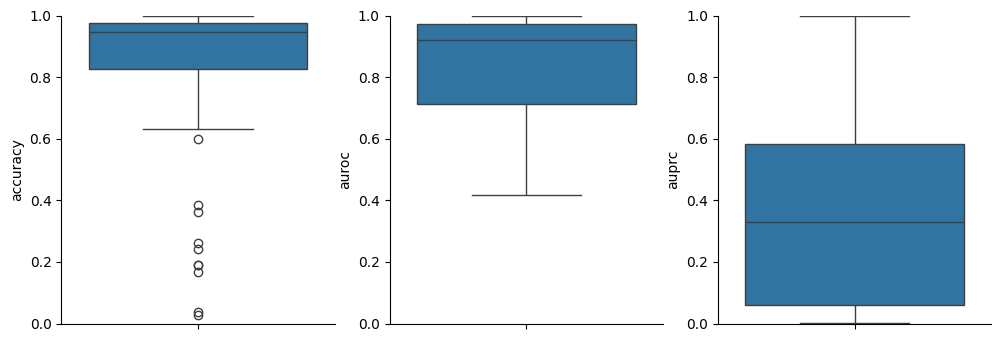

In [12]:
# Metrics

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

b = sns.boxplot(data=mhcbench_v2_result_df, y='accuracy', ax=axs[0])
b.set(ylim=(0,1))

b = sns.boxplot(data=mhcbench_v2_result_df, y='auroc', ax=axs[1])
b.set(ylim=(0,1))

b = sns.boxplot(data=mhcbench_v2_result_df, y='auprc', ax=axs[2])
b.set(ylim=(0,1))

sns.despine(top=True,right=True)


In [13]:
mhcbench_v2_result_df.median()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


peptide_count    18961.000000
accuracy             0.948028
f1                   0.076636
auroc                0.919944
auprc                0.329186
rule_count          59.000000
dtype: float64